In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, glob, math
from itertools import cycle
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score, recall_score, f1_score, precision_score, PrecisionRecallDisplay
np.random.seed(1234)

<h1> Data Preparation </h1>

<h2> Data loading with split by recordings </h2>

In [23]:
with open('trainset_python/python/class_names.txt') as f:
    classes = f.readlines()

for i,c in enumerate(classes):
    classes[i] = c.strip()

In [24]:
with open('trainset_python/python/feature_names.txt') as f:
    features = f.readlines()

for i,feature in enumerate(features):
    features[i] = feature.strip()

In [25]:
#all files in one dataframe
idx = pd.Series([i for i in range(100)])

rootdir = os. getcwd()
files_stand_train = pd.DataFrame([])
labels_train_all = pd.DataFrame([])
data_stand_train = pd.DataFrame([])
files_stand_test = pd.DataFrame([])
labels_test_all = pd.DataFrame([])
data_stand_test = pd.DataFrame([])
    
for i,f in enumerate(glob.glob(rootdir + '/trainset_python/**/*.npy', recursive=True)):
    if (i % 2) == 0:
        label = pd.DataFrame(np.load(f))
        
        if (i<320 or i>399) and (i<720 or i>799) and (i<1120 or i>1199) and (i<1520 or i>1599) and (i<1920 or i>1999) and (i<2320 or i>2399):
            for j, col in enumerate(label.columns):
                if j == 0:
                    label = label.rename(columns={label.columns[0]: "overall_class_vote"})
                else:
                    label = label.rename(columns={col: "class_vote_" + str(j)})
            if labels_train_all.empty:
                labels_train_all = label
            else:
                idx = idx + (j*100)
                label.index = idx
                labels_train_all = pd.concat([labels_train_all,label])
        else:
            for j, col in enumerate(label.columns):
                if j == 0:
                    label = label.rename(columns={label.columns[0]: "overall_class_vote"})
                else:
                    label = label.rename(columns={col: "class_vote_" + str(j)})
            if labels_test_all.empty:
                labels_test_all = label
            else:
                idx = idx + (j*100)
                label.index = idx
                labels_test_all = pd.concat([labels_test_all,label])
    else:
        file_stand = pd.DataFrame(StandardScaler().fit_transform(np.load(f)), columns = features)

        if (i<320 or i>399) and (i<720 or i>799) and (i<1120 or i>1199) and (i<1520 or i>1599) and (i<1920 or i>1999) and (i<2320 or i>2399):
            if files_stand_train.empty:
                files_stand_train = file_stand
            else:
                idx = idx + (i*100)
                file_stand.index = idx
                files_stand_train = pd.concat([files_stand_train,file_stand])        
        else:
            if files_stand_test.empty:
                files_stand_test = file_stand
            else:
                idx = idx + (i*100)
                file_stand.index = idx
                files_stand_test = pd.concat([files_stand_test,file_stand])

labels_train_all.index = pd.Series([i for i in range(len(labels_train_all))])
files_stand_train.index = pd.Series([i for i in range(len(files_stand_train))])
labels_test_all.index = pd.Series([i for i in range(len(labels_test_all))])
files_stand_test.index = pd.Series([i for i in range(len(files_stand_test))])

In [26]:
#files_stand_test
files_stand_train

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,-0.783543,1.375707,-0.591246,-0.659101,-0.683010,-0.730899,-0.804107,-0.635452,-0.684022,-0.855244,...,0.262013,-0.497756,-0.163193,2.487361,0.333874,0.450709,0.745307,0.213698,1.540373,-0.710768
1,0.167208,-0.526000,-0.605283,-0.644997,-0.667503,-0.714700,-0.783143,-0.637137,-0.684710,-0.702930,...,-1.427318,0.074920,-0.115683,0.804020,1.606063,-1.114032,-0.851041,-0.778650,-0.453525,0.479612
2,0.461319,-0.636900,-0.578792,-0.649733,-0.671045,-0.717349,-0.780945,-0.636216,-0.683018,-0.700525,...,-0.224404,-0.914364,-0.323859,-1.849531,1.352744,-0.486672,-1.106791,-0.014905,-0.742246,0.318966
3,0.854948,-0.895040,-0.577355,-0.647228,1.701700,1.539210,1.367054,1.740341,1.636040,1.694016,...,-0.778076,-0.928394,-0.319547,-0.412680,0.388380,0.980363,-0.796871,-0.166418,-1.076733,-0.265297
4,0.822960,-0.542231,-0.608296,1.754146,1.784766,1.610830,1.431633,1.783958,1.649853,1.716896,...,-1.623868,-1.209971,-0.311791,-0.557688,-0.121353,1.415610,-0.072873,-0.584790,-0.472864,-0.260567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,-0.784188,-0.480545,0.359744,0.366920,0.519785,0.643328,0.696041,0.645033,0.646284,0.552000,...,-0.571604,-0.178523,-0.308753,-1.086840,-0.754005,-0.178426,-0.977838,-0.019912,-0.117225,-0.418496
95996,-0.550090,0.090796,0.420931,0.424971,0.566760,0.524665,0.487289,0.295590,0.458490,0.467109,...,-0.577851,-0.085528,-0.353423,-1.027504,0.005354,0.303063,0.256371,0.206974,0.047860,-0.761570
95997,-0.399315,1.167275,0.557454,-0.922688,-0.837633,-0.734881,0.655999,0.557689,0.547724,0.636580,...,-0.717911,-0.187067,-0.429061,0.265880,-1.006210,-0.324548,-0.902801,-1.410408,-0.292729,-0.550697
95998,-0.899253,-0.824132,0.544537,0.515400,0.604888,0.623854,0.558855,0.537722,0.554042,0.633540,...,-0.393843,-0.163042,-0.376325,-0.074304,0.164449,-0.087280,-0.865935,0.138146,0.082868,-0.152083


<h2> Comparison of class distribution</h2>

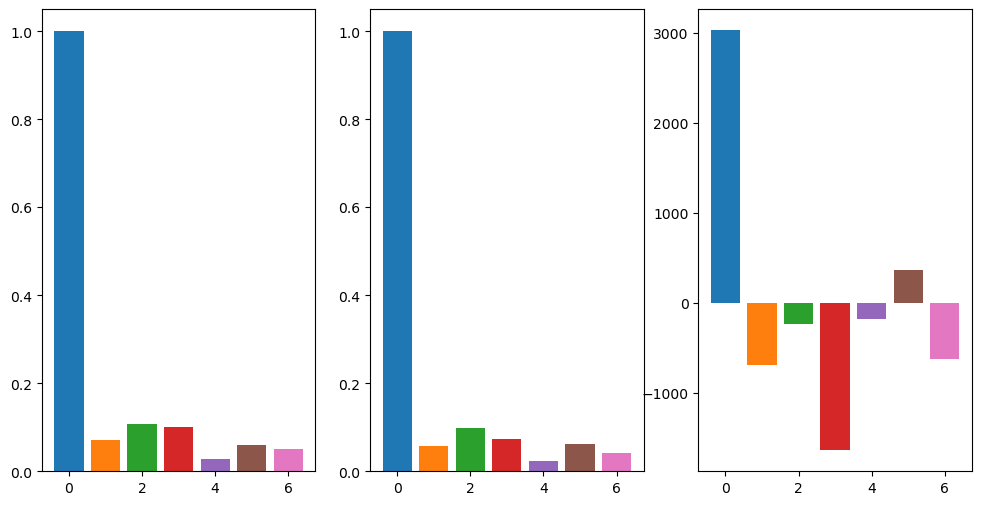

In [27]:
labels_train_all_grouped = labels_train_all.groupby(labels_train_all.overall_class_vote)
labels_test_all_grouped = labels_test_all.groupby(labels_test_all.overall_class_vote)
classes_train = dict([])
classes_test = dict([])
train_amounts = []
test_amounts = []

fix, axs = plt.subplots(1,3, figsize=(12,6))

for i in range(0,7):
    classes_train[i] = labels_train_all_grouped.get_group(i)
    classes_test[i] = labels_test_all_grouped.get_group(i)

for c in classes_train:
    train_amounts.append(len(classes_train[c]))
    test_amounts.append(len(classes_test[c])*4)
    axs[0].bar(c, len(classes_train[c])/len(classes_train[0]))
    axs[1].bar(c, len(classes_test[c])/len(classes_test[0]))
    axs[2].bar(c, test_amounts[c] - train_amounts[c])
plt.show()

<h2> Drop samples with disagreement </h2>

In [28]:
def sample_dataframe_by_threshold(file_stand, lables):
    dropped_indices = []
    nr_annotators = [0, 0, 0, 0, 0]

    invalid_samples = 0
    for i, sample in enumerate(file_stand.copy().to_numpy()[:, -7:]):
        sample_has_nans = 0
        sample_nan_idx = []
        for l, val in enumerate(sample):
            if math.isnan(val):
                sample_nan_idx.append(l)
                sample_has_nans += 1
        # remove nans from sample
        sample = np.delete(sample, sample_nan_idx)
        # print(sample)
        classes_vote = [np.count_nonzero((sample == 1) | (sample == 1.0)), np.count_nonzero((sample == 2) | (sample == 2.0)), np.count_nonzero((sample == 3) | (sample == 3.0)),
                        np.count_nonzero((sample == 4) | (sample == 4.0)), np.count_nonzero((sample == 5) | (sample == 5.0)), np.count_nonzero((sample == 6) | (sample == 6.0))]
        # accept fragments with no votes and votes above current threshold
        if np.max(classes_vote) / len(sample) > 0:
            #accept all samples for 3 annotators
            """if len(sample) == 3 and np.max(classes_vote) / len(sample) < 3/3:
                invalid_samples += 1
                inner_list_dropped_indices.append(i)
                nr_annotators[0] += 1"""
            if len(sample) == 4 and np.max(classes_vote) / len(sample) < 3/4:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[1] += 1
            elif len(sample) == 5 and np.max(classes_vote) / len(sample) < 3/5:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[2] += 1
            elif len(sample) == 6 and np.max(classes_vote) / len(sample) < 4/6:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[3] += 1
            elif len(sample) == 7 and np.max(classes_vote) / len(sample) < 5/7:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[4] += 1
    # drop the samples with < threshold than selected
    sampled_dataframe = file_stand.drop(dropped_indices).reset_index()
    lables_agree = lables.drop(dropped_indices)
    # drop vote columns and index_column
    sampled_dataframe = sampled_dataframe.iloc[:, 1:-8]
    #print(nr_annotators)
    return sampled_dataframe, lables_agree

In [29]:
data_stand_train = pd.DataFrame(pd.concat((files_stand_train, labels_train_all), axis=1))
data_stand_test = pd.DataFrame(pd.concat((files_stand_test, labels_test_all), axis=1))

In [30]:
files_train, labels_train = sample_dataframe_by_threshold(data_stand_train, labels_train_all)
files_test, labels_test = sample_dataframe_by_threshold(data_stand_test, labels_test_all)

labels_train.to_csv('data_temp/labels_train', index=False)
labels_test.to_csv('data_temp/labels_test', index=False)

In [31]:
files_train

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.167208,-0.526000,-0.605283,-0.644997,-0.667503,-0.714700,-0.783143,-0.637137,-0.684710,-0.702930,...,-1.427318,0.074920,-0.115683,0.804020,1.606063,-1.114032,-0.851041,-0.778650,-0.453525,0.479612
1,0.461319,-0.636900,-0.578792,-0.649733,-0.671045,-0.717349,-0.780945,-0.636216,-0.683018,-0.700525,...,-0.224404,-0.914364,-0.323859,-1.849531,1.352744,-0.486672,-1.106791,-0.014905,-0.742246,0.318966
2,0.854948,-0.895040,-0.577355,-0.647228,1.701700,1.539210,1.367054,1.740341,1.636040,1.694016,...,-0.778076,-0.928394,-0.319547,-0.412680,0.388380,0.980363,-0.796871,-0.166418,-1.076733,-0.265297
3,0.822960,-0.542231,-0.608296,1.754146,1.784766,1.610830,1.431633,1.783958,1.649853,1.716896,...,-1.623868,-1.209971,-0.311791,-0.557688,-0.121353,1.415610,-0.072873,-0.584790,-0.472864,-0.260567
4,1.185489,-0.650381,1.920336,1.733858,1.769065,1.630653,1.431748,1.716913,1.575559,1.648439,...,-0.204925,-1.441965,0.677037,-0.175322,-0.255244,0.513171,-1.169459,-0.658233,-0.090633,0.319449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79589,-0.784188,-0.480545,0.359744,0.366920,0.519785,0.643328,0.696041,0.645033,0.646284,0.552000,...,-0.571604,-0.178523,-0.308753,-1.086840,-0.754005,-0.178426,-0.977838,-0.019912,-0.117225,-0.418496
79590,-0.550090,0.090796,0.420931,0.424971,0.566760,0.524665,0.487289,0.295590,0.458490,0.467109,...,-0.577851,-0.085528,-0.353423,-1.027504,0.005354,0.303063,0.256371,0.206974,0.047860,-0.761570
79591,-0.399315,1.167275,0.557454,-0.922688,-0.837633,-0.734881,0.655999,0.557689,0.547724,0.636580,...,-0.717911,-0.187067,-0.429061,0.265880,-1.006210,-0.324548,-0.902801,-1.410408,-0.292729,-0.550697
79592,-0.899253,-0.824132,0.544537,0.515400,0.604888,0.623854,0.558855,0.537722,0.554042,0.633540,...,-0.393843,-0.163042,-0.376325,-0.074304,0.164449,-0.087280,-0.865935,0.138146,0.082868,-0.152083


In [32]:
files_test

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,-1.210150,-1.451327,0.700008,0.819156,0.650910,0.675764,0.485884,0.411237,0.588675,0.303126,...,-0.802064,0.166120,0.214619,0.410485,2.301344,2.001368,-0.140155,-1.007706,-0.801168,1.357375
1,-0.933905,-0.678547,0.890109,1.109068,1.122557,1.333728,1.115481,0.993599,1.243750,1.362293,...,-0.216428,-0.645085,-0.543393,-0.316014,-0.177167,1.054301,-0.613450,-1.180495,-0.232093,-0.779992
2,-0.529404,-0.178950,-0.889144,-0.789354,0.648754,0.862564,0.733247,0.468184,1.305525,1.295229,...,0.070691,-0.551617,-0.440567,-0.338616,0.086395,-1.310553,-1.195758,-0.415584,-0.472400,-0.155495
3,-1.101625,-1.199296,0.769815,0.937364,0.947392,1.109752,0.890032,0.794324,-0.917671,-0.875388,...,-1.430626,-0.809898,-0.532892,0.219031,0.529697,-0.494937,-1.027985,-0.650144,-1.070194,-1.026656
4,-1.037497,-1.136790,-0.863547,-0.782905,-0.841894,-0.905041,-0.852406,0.467126,0.599287,0.686572,...,-0.480207,-0.505512,-1.165949,1.992365,-1.246202,0.038057,-0.906738,-1.106271,-1.311368,-1.080379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20149,-0.331513,0.356134,-0.844403,-0.858645,-0.641962,-0.805758,-0.697388,-0.642756,-0.856450,-0.796840,...,-0.286449,-0.457386,-0.313910,1.092455,-1.203601,0.934860,-0.202530,-0.613064,0.010541,0.138739
20150,-1.220233,-0.828050,-0.903588,-0.687250,-0.680983,-0.653949,-0.680398,-0.549913,-0.753115,-0.687278,...,0.024849,-0.176945,-0.326877,0.339264,0.115136,-0.538031,1.039460,0.106102,-0.789529,0.160393
20151,-0.438986,-0.523291,-0.908066,-0.808672,-0.801250,-0.614802,-0.844231,-0.732196,-0.812538,-0.531270,...,0.102378,-0.428485,-0.163334,-0.339807,1.281501,1.089032,0.429298,0.445736,-0.984278,-0.468615
20152,-0.856478,-0.580928,-0.195463,-0.084748,-0.035737,-0.576595,-0.475360,-0.519312,-0.610353,-0.561646,...,-0.584563,-0.117808,-0.142838,-0.283224,-0.190104,-0.195900,0.225551,-1.174491,-0.516408,0.472931


<h2>Comparison after drops</h2>

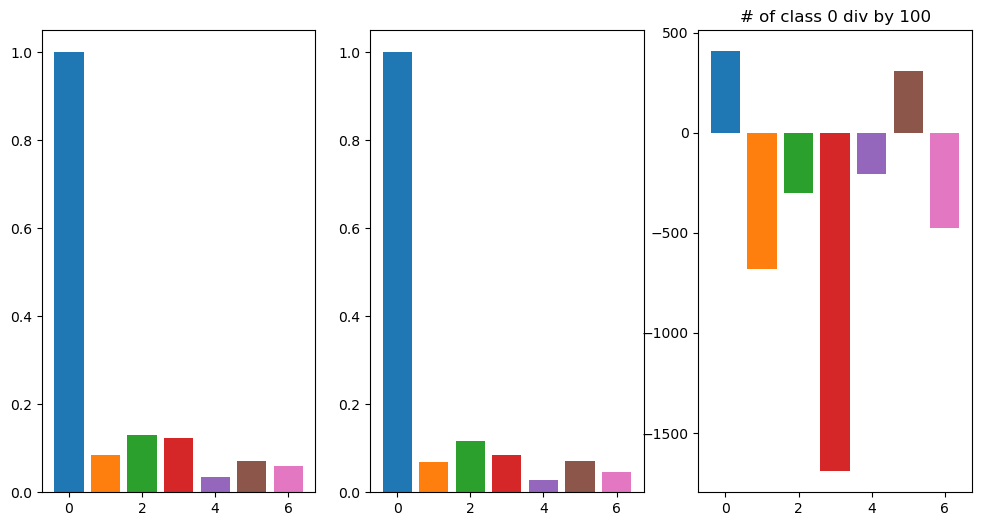

In [33]:
labels_train_grouped = labels_train.groupby(labels_train.overall_class_vote)
labels_test_grouped = labels_test.groupby(labels_test.overall_class_vote)
classes_train = dict([])
classes_test = dict([])
train_amounts = []
test_amounts = []

fix, axs = plt.subplots(1,3, figsize=(12,6))

for i in range(0,7):
    classes_train[i] = labels_train_grouped.get_group(i)
    classes_test[i] = labels_test_grouped.get_group(i)

for c in classes_train:
    train_amounts.append(len(classes_train[c]))
    test_amounts.append(len(classes_test[c])*4)
    axs[0].bar(c, len(classes_train[c])/len(classes_train[0]))
    axs[1].bar(c, len(classes_test[c])/len(classes_test[0]))
    if c == 0:
        axs[2].bar(c, (test_amounts[c] - train_amounts[c])/10)
    else:
        axs[2].bar(c, test_amounts[c] - train_amounts[c])
        
axs[2].set_title('# of class 0 div by 100')
plt.show()

<h2> Drop correlated features </h2>

In [34]:
# drop highly correlated features
corr_train = files_train.corr()

# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(corr_matrix, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features_train = correlation(corr_train, 0.9)
files_train = files_train.drop(corr_features_train,axis=1)
files_test = files_test.drop(corr_features_train,axis=1)

In [35]:
files_train

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.167208,-0.526000,-0.605283,-0.644997,-0.667503,-0.714700,-0.783143,-0.637137,-0.684710,-0.702930,...,-1.427318,0.074920,-0.115683,0.804020,1.606063,-1.114032,-0.851041,-0.778650,-0.453525,0.479612
1,0.461319,-0.636900,-0.578792,-0.649733,-0.671045,-0.717349,-0.780945,-0.636216,-0.683018,-0.700525,...,-0.224404,-0.914364,-0.323859,-1.849531,1.352744,-0.486672,-1.106791,-0.014905,-0.742246,0.318966
2,0.854948,-0.895040,-0.577355,-0.647228,1.701700,1.539210,1.367054,1.740341,1.636040,1.694016,...,-0.778076,-0.928394,-0.319547,-0.412680,0.388380,0.980363,-0.796871,-0.166418,-1.076733,-0.265297
3,0.822960,-0.542231,-0.608296,1.754146,1.784766,1.610830,1.431633,1.783958,1.649853,1.716896,...,-1.623868,-1.209971,-0.311791,-0.557688,-0.121353,1.415610,-0.072873,-0.584790,-0.472864,-0.260567
4,1.185489,-0.650381,1.920336,1.733858,1.769065,1.630653,1.431748,1.716913,1.575559,1.648439,...,-0.204925,-1.441965,0.677037,-0.175322,-0.255244,0.513171,-1.169459,-0.658233,-0.090633,0.319449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79589,-0.784188,-0.480545,0.359744,0.366920,0.519785,0.643328,0.696041,0.645033,0.646284,0.552000,...,-0.571604,-0.178523,-0.308753,-1.086840,-0.754005,-0.178426,-0.977838,-0.019912,-0.117225,-0.418496
79590,-0.550090,0.090796,0.420931,0.424971,0.566760,0.524665,0.487289,0.295590,0.458490,0.467109,...,-0.577851,-0.085528,-0.353423,-1.027504,0.005354,0.303063,0.256371,0.206974,0.047860,-0.761570
79591,-0.399315,1.167275,0.557454,-0.922688,-0.837633,-0.734881,0.655999,0.557689,0.547724,0.636580,...,-0.717911,-0.187067,-0.429061,0.265880,-1.006210,-0.324548,-0.902801,-1.410408,-0.292729,-0.550697
79592,-0.899253,-0.824132,0.544537,0.515400,0.604888,0.623854,0.558855,0.537722,0.554042,0.633540,...,-0.393843,-0.163042,-0.376325,-0.074304,0.164449,-0.087280,-0.865935,0.138146,0.082868,-0.152083


In [36]:
files_test

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,-1.210150,-1.451327,0.700008,0.819156,0.650910,0.675764,0.485884,0.411237,0.588675,0.303126,...,-0.802064,0.166120,0.214619,0.410485,2.301344,2.001368,-0.140155,-1.007706,-0.801168,1.357375
1,-0.933905,-0.678547,0.890109,1.109068,1.122557,1.333728,1.115481,0.993599,1.243750,1.362293,...,-0.216428,-0.645085,-0.543393,-0.316014,-0.177167,1.054301,-0.613450,-1.180495,-0.232093,-0.779992
2,-0.529404,-0.178950,-0.889144,-0.789354,0.648754,0.862564,0.733247,0.468184,1.305525,1.295229,...,0.070691,-0.551617,-0.440567,-0.338616,0.086395,-1.310553,-1.195758,-0.415584,-0.472400,-0.155495
3,-1.101625,-1.199296,0.769815,0.937364,0.947392,1.109752,0.890032,0.794324,-0.917671,-0.875388,...,-1.430626,-0.809898,-0.532892,0.219031,0.529697,-0.494937,-1.027985,-0.650144,-1.070194,-1.026656
4,-1.037497,-1.136790,-0.863547,-0.782905,-0.841894,-0.905041,-0.852406,0.467126,0.599287,0.686572,...,-0.480207,-0.505512,-1.165949,1.992365,-1.246202,0.038057,-0.906738,-1.106271,-1.311368,-1.080379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20149,-0.331513,0.356134,-0.844403,-0.858645,-0.641962,-0.805758,-0.697388,-0.642756,-0.856450,-0.796840,...,-0.286449,-0.457386,-0.313910,1.092455,-1.203601,0.934860,-0.202530,-0.613064,0.010541,0.138739
20150,-1.220233,-0.828050,-0.903588,-0.687250,-0.680983,-0.653949,-0.680398,-0.549913,-0.753115,-0.687278,...,0.024849,-0.176945,-0.326877,0.339264,0.115136,-0.538031,1.039460,0.106102,-0.789529,0.160393
20151,-0.438986,-0.523291,-0.908066,-0.808672,-0.801250,-0.614802,-0.844231,-0.732196,-0.812538,-0.531270,...,0.102378,-0.428485,-0.163334,-0.339807,1.281501,1.089032,0.429298,0.445736,-0.984278,-0.468615
20152,-0.856478,-0.580928,-0.195463,-0.084748,-0.035737,-0.576595,-0.475360,-0.519312,-0.610353,-0.561646,...,-0.584563,-0.117808,-0.142838,-0.283224,-0.190104,-0.195900,0.225551,-1.174491,-0.516408,0.472931


<h2> Select features</h2>

In [37]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

'''
twenty_cols = SelectKBest(mutual_info_classif, k=20)
twenty_cols.fit(files_train, lables_train['overall_class_vote'])
selected_features_20 = files_agree.columns[twenty_cols.get_support()]
'''

fifty_cols = SelectKBest(mutual_info_classif, k=50)
fifty_cols.fit(files_train, labels_train['overall_class_vote'])
selected_features_50 = files_train.columns[fifty_cols.get_support()]

In [38]:
pd.DataFrame(selected_features_50)

,0
0,zcr_mean
1,yin_5
2,yin_6
3,yin_7
4,yin_9
5,raw_melspect_mean_4
6,raw_melspect_mean_5
7,raw_melspect_mean_6
8,raw_melspect_mean_7
9,raw_melspect_mean_8


In [39]:
files_train_50 = pd.DataFrame()
files_test_50 = pd.DataFrame()

for idx in selected_features_50:
    files_train_50[idx] = files_train[idx]
    files_test_50[idx] = files_test[idx]

files_train_50.to_csv('data_temp/files_train_50', index=False)
files_test_50.to_csv('data_temp/files_test_50', index=False)

In [40]:
files_train_50

,zcr_mean,yin_5,yin_6,yin_7,yin_9,raw_melspect_mean_4,raw_melspect_mean_5,raw_melspect_mean_6,raw_melspect_mean_7,raw_melspect_mean_8,...,raw_contrast_mean_3,cln_flatness_mean,cln_centroid_mean,cln_centroid_std,cln_flux_mean,cln_flux_std,cln_energy_std,cln_bandwidth_mean,cln_contrast_mean_3,cln_contrast_mean_4
0,0.167208,-0.637137,-0.684710,-0.702930,-0.737234,0.413676,0.351911,0.182678,-0.001713,-0.367584,...,-0.193519,0.623446,0.948781,-0.596810,-0.447192,-0.487065,-0.443302,-0.147406,-1.066098,-1.427318
1,0.461319,-0.636216,-0.683018,-0.700525,-0.734306,-0.855740,0.033231,-0.059496,-0.188944,-0.213440,...,-0.444102,0.947370,0.847815,-0.609965,-0.548157,-0.530030,-0.363591,-0.271310,-1.044733,-0.224404
2,0.854948,1.740341,1.636040,1.694016,1.586592,0.191515,-0.750290,-0.783740,-0.732563,-0.692779,...,-0.664926,0.872882,1.227718,-0.055447,-0.612837,-0.637614,-0.269222,0.188035,-0.305408,-0.778076
3,0.822960,1.783958,1.649853,1.716896,1.608626,-0.165756,0.174313,-0.412357,-0.677561,-0.748280,...,-0.219770,1.150775,1.022415,-0.495100,-0.791180,-0.688336,-0.372902,0.320006,-0.382392,-1.623868
4,1.185489,1.716913,1.575559,1.648439,1.536332,0.244198,-0.320617,-0.825520,-0.931514,-0.686089,...,-0.886440,0.438736,0.705754,-0.851837,-0.672211,-0.523607,-0.303215,0.116443,-0.754747,-0.204925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79589,-0.784188,0.645033,0.646284,0.552000,0.493578,-0.253069,-0.164052,-0.080371,-0.169849,-0.575375,...,-0.576371,0.705715,0.601116,-0.356172,-0.315970,-0.345021,-0.334270,0.255686,-0.615419,-0.571604
79590,-0.550090,0.295590,0.458490,0.467109,0.664233,-0.258990,-0.235127,-0.273793,-0.371793,-0.665008,...,-0.440799,0.700285,0.597910,-0.488368,-0.316126,-0.345134,-0.337377,0.230824,-0.477265,-0.577851
79591,-0.399315,0.557689,0.547724,0.636580,0.527038,-0.069832,-0.032935,-0.152274,-0.376390,-0.509964,...,-0.547931,0.669002,0.547564,-0.105533,-0.314789,-0.341100,-0.316947,0.164324,-0.722047,-0.717911
79592,-0.899253,0.537722,0.554042,0.633540,0.499153,-0.177920,-0.416038,-0.465059,-0.301779,-0.434231,...,-0.795280,0.682780,0.562595,-0.347868,-0.316113,-0.345006,-0.334953,0.217648,-0.715435,-0.393843


<h2> Test data load </h2>

In [68]:
test_data = []
rootdir = os. getcwd()

for i,f in enumerate(glob.glob(rootdir + '/testset_python/**/*.npy', recursive=True)):
    file_stand = pd.DataFrame(StandardScaler().fit_transform(np.load(f)), columns = features)
    test_data.append(file_stand)

In [69]:
test_data_50 = []

for i,file in enumerate(test_data):
    file_50 = pd.DataFrame()
    for idx in selected_features_50:
        file_50[idx] = file[idx]
    test_data_50.append(file_50)
    
    if i < 10:
        file_50.to_csv('data_test_temp/file_train_50_0' + str(i), index=False)
    else:
        file_50.to_csv('data_test_temp/file_train_50_' + str(i), index=False)

    
test_data_50[0] 

,zcr_mean,yin_5,yin_6,yin_7,yin_9,raw_melspect_mean_4,raw_melspect_mean_5,raw_melspect_mean_6,raw_melspect_mean_7,raw_melspect_mean_8,...,raw_contrast_mean_3,cln_flatness_mean,cln_centroid_mean,cln_centroid_std,cln_flux_mean,cln_flux_std,cln_energy_std,cln_bandwidth_mean,cln_contrast_mean_3,cln_contrast_mean_4
0,1.090693,-0.512714,-0.520487,-0.515486,-0.512356,0.278055,0.097386,-0.070374,-0.052718,-0.041288,...,-0.864053,0.639141,0.266353,-0.719463,-0.110964,-0.053905,-0.040405,-0.361710,-0.550452,0.477766
1,1.146901,-0.455274,0.029221,-0.548455,-0.508179,0.213967,0.164607,-0.050898,-0.118182,-0.004096,...,-0.741515,0.510421,-0.256923,-0.476210,-0.109205,-0.056305,-0.045292,-0.571376,-0.638926,-0.433546
2,1.044289,0.065664,0.049803,0.766311,-0.432778,0.127369,0.076054,0.024020,-0.049265,0.094439,...,-0.754992,0.445774,-0.372376,-0.458904,-0.109759,-0.057369,-0.046494,-0.422563,-0.500320,-0.618416
3,0.867169,-0.487870,-0.547454,-0.542343,-0.538185,-0.046420,0.031460,-0.056230,0.027299,-0.013696,...,-0.605544,0.299699,-0.567091,-0.174691,-0.110324,-0.056388,-0.045344,-0.292037,-0.228992,-0.571831
4,0.834490,-0.550949,-0.463770,-0.553424,-0.343792,-0.119741,-0.101143,-0.100501,0.043563,0.139705,...,-0.830997,0.835813,0.015154,-0.264491,-0.115701,-0.054215,-0.041691,-0.000234,-0.487258,-0.461646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.898149,-0.524865,-0.542759,-0.495423,-0.532033,-0.402344,-0.263912,-0.447585,-0.430969,-0.304931,...,-0.618580,-0.081205,-0.196853,-0.131500,-0.124998,-0.055138,-0.048167,0.751100,-0.244763,-0.626714
2996,-0.904031,-0.515728,-0.524695,-0.542980,-0.537427,-0.319425,-0.382510,-0.204826,-0.063589,-0.294707,...,-0.782590,-1.137629,0.127529,0.032868,-0.093218,-0.046114,-0.046528,-0.302447,-0.501680,-0.456187
2997,-0.860895,-0.501815,-0.513464,-0.511400,-0.546182,-0.256575,-0.175083,-0.304338,-0.317555,-0.292801,...,-0.504433,-1.517389,0.582718,-0.231680,-0.085948,-0.052388,-0.050000,-1.283758,-0.119736,-0.841494
2998,-0.920371,-0.511420,-0.523336,-0.485893,-0.482012,-0.330273,-0.455143,-0.455569,-0.252554,-0.400509,...,-0.761185,-1.487441,0.435290,-0.444000,-0.073711,-0.050186,-0.044779,-2.177737,-0.527614,-0.320836


# Reload saved Data to skip rerunning previous steps

In [72]:
labels_test = pd.read_csv('data_temp/labels_test')
labels_train = pd.read_csv('data_temp/labels_train')
files_test_50 = pd.read_csv('data_temp/files_test_50')
files_train_50 = pd.read_csv('data_temp/files_train_50')

data_test_50 = []
for i in range(10):
    data_test_50.append(pd.read_csv('data_test_temp/file_train_50_0' + str(i)))
for i in range(10,16):
    data_test_50.append(pd.read_csv('data_test_temp/file_train_50_' + str(i)))

<h1> Split, Evaluation set-up, Post-processing set-up</h1>

<h2> Train Test and sample weights</h2>

<h3>split</h3>

In [3]:
X_train = files_train_50
X_test = files_test_50
y_train = labels_train['overall_class_vote']
y_test = labels_test['overall_class_vote']

<h3>weights</h3>

In [4]:
''' add wights to put more focus on important classes and less on not so important ones'''
weights_train = np.ones(y_train.shape)
weights_train[y_train[:]==0] = 0.25        # lots of samples for other and less reward -> downweight
#weights_train[y_train[:]==2] = 0.1         # class 2 (cowpig1) shouldn't be falsly predicted and missing it is not important -> downweight

<h2> Evaluation </h2>

<h3>PR-curve</h3>

In [5]:
def prec_rec(classifier, X_test, y_test, title='Precision-recall curve', post = False):
    predictions = classifier.predict(X_test)
    if post:
        predictions = postprocess(predictions)
    y_score = classifier.predict_proba(X_test)
    classes=[0, 1, 2, 3, 4, 5, 6]
    
    y_test_bin = label_binarize(y_test, classes=classes)
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(7):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    
    all_precision = np.unique(np.concatenate([precision[i] for i in range(len(classes))]))
    
    # Then interpolate all ROC curves at this points
    mean_recall = np.zeros_like(all_precision)
    for i in range(len(classes)):
        mean_recall += np.interp(all_precision, precision[i], recall[i])

    # Finally average it and compute AUC
    mean_recall /= len(classes)

    precision["macro"] = all_precision
    recall["macro"] = mean_recall
    average_precision["macro"] = average_precision_score(y_test_bin, y_score, average="macro")   
    
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal", 'r', 'g'])

    _, ax = plt.subplots(figsize=(7, 8))

    lines, labels = [], []

    display_1 = PrecisionRecallDisplay(
        recall=recall["macro"],
        precision=precision["macro"],
        average_precision=average_precision["macro"],
    )
    display_1.plot(ax=ax, name="Macro-average precision-recall", color="gold")

    for i, color in zip(range(7), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)
    
    handles, labels = display_1.ax_.get_legend_handles_labels()

    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title(title)

    plt.show()

<h3>expected savings</h3>

In [6]:
def get_savings(predictions, y_true, detail=0):
    '''
    detail: 0 -> show all information
            1 -> show conf_matrix, heatmap, savings
            2 -> show heatmap and savings
    '''
    
    f1 = f1_score(y_true, predictions, average="macro")
    precision = precision_score(y_true, predictions, average="macro")
    recall = recall_score(y_true, predictions, average="macro")
    conf_mat = confusion_matrix(y_true, predictions)

    if detail == 1 or detail == 0:
        if detail == 0:
            print('F1 =',f1)
            print('Precision =',precision)
            print('Recall =', recall)
        print('confusion matrix\n', conf_mat)
    
    cost_matrix = [[0.05, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2],
                   [-0.25, 1, -0.3, -0.1, -0.1, -0.1, -0.1],
                   [-0.02, -0.1, 1, -0.1, -0.1, -0.1, -0.1],
                   [-0.25, -0.1, -0.3, 1, -0.1, -0.1, -0.1],
                   [-0.25, -0.1, -0.3, -0.1, 1, -0.1, -0.1],
                   [-0.25, -0.1, -0.3, -0.1, -0.1, 1, -0.1],
                   [-0.25, -0.1, -0.3, -0.1, -0.1, -0.1, 1]]

    savings = np.multiply(cost_matrix, conf_mat)
    max_savings = np.sum(np.multiply(cost_matrix,  confusion_matrix(y_true, y_true)))
    
    # set [0][0] to 2nd highest value to get better heatmap and plot the heatmap
    heat = np.copy(conf_mat)
    ind = np.argpartition(heat.max(1), -2)[-2:][0]
    heat[0,0] = heat.max(1)[ind]
    sns.heatmap(heat,cmap=plt.cm.CMRmap_r)
    plt.show()
    
    print('max savings: ', max_savings)
    print('savings: ', np.sum(savings), '\n')

<h2> Postprocessing (maybe consider call length) </h2>

In [7]:
def postprocess(preds):
    preds_post = np.copy(preds)
    i_max = len(preds_post)
    for i,c in enumerate(preds_post):
        
        # what to do with first prediction?
        if i == 0:
            pass
        
        # 
        if i > 0 and i < i_max-1:
            if preds_post[i-1] == 2 and i > 1 and i < i_max-2:
                if preds_post[i-2] == preds_post[i+2]:
                    preds_post[i] = preds_post[i-1]
        
            # case yny flip to yyy, important to do before nyn to nnn
            if preds_post[i-1] == preds_post[i+1] and preds_post[i-1] != 0:
                preds_post[i] = preds_post[i-1]
                       
            # case nnynn flip to nnnnn if class not grswoo (because they have short calls)
            if  i > 1 and i < i_max-2:
                if preds_post[i-2] == preds_post[i-1] == preds_post[i+1] == preds_post[i+2] and preds_post[i] != 5:
                    preds_post[i] = preds_post[i-1]

        
        '''
        if i > 1 and i < len(preds_post)-2:
            if preds_post[i-2] == preds_post[i-1] == preds_post[i+1] == preds_post[i+2]:
                preds_post[i] = preds_post[i-1]
        '''
    return preds_post

<h3>Visualization</h3>

In [73]:
def post_process_viz(preds, preds_post, y_test, start=0, stop=150):
    
    fix,axs = plt.subplots(3,1,figsize=(20,15))
    for i,c in enumerate(preds[start:stop]):
        axs[0].bar(i,c,color='b',width=1)
        axs[0].set_title('predictions without post processing')
    for i,c in enumerate(preds_post[start:stop]):
        axs[1].bar(i,c,color='b',width=1)
        axs[1].set_title('predictions after post processing')
    for i,c in enumerate(y_test[start:stop]):
        axs[2].bar(i,c,color='b',width=1)
        axs[2].set_title('True calls')
    plt.show()

<h1> Classifiers </h1>

<h2> Random forest classifier </h2>

<h3> Standard init </h3>

<h4> Train </h4>

In [159]:
classifier_50 = RandomForestClassifier(random_state = 42)
classifier_50.fit(X_train,y_train, sample_weight = weights_train)

RandomForestClassifier(random_state=42)

<h4> Predict and post-process </h4>

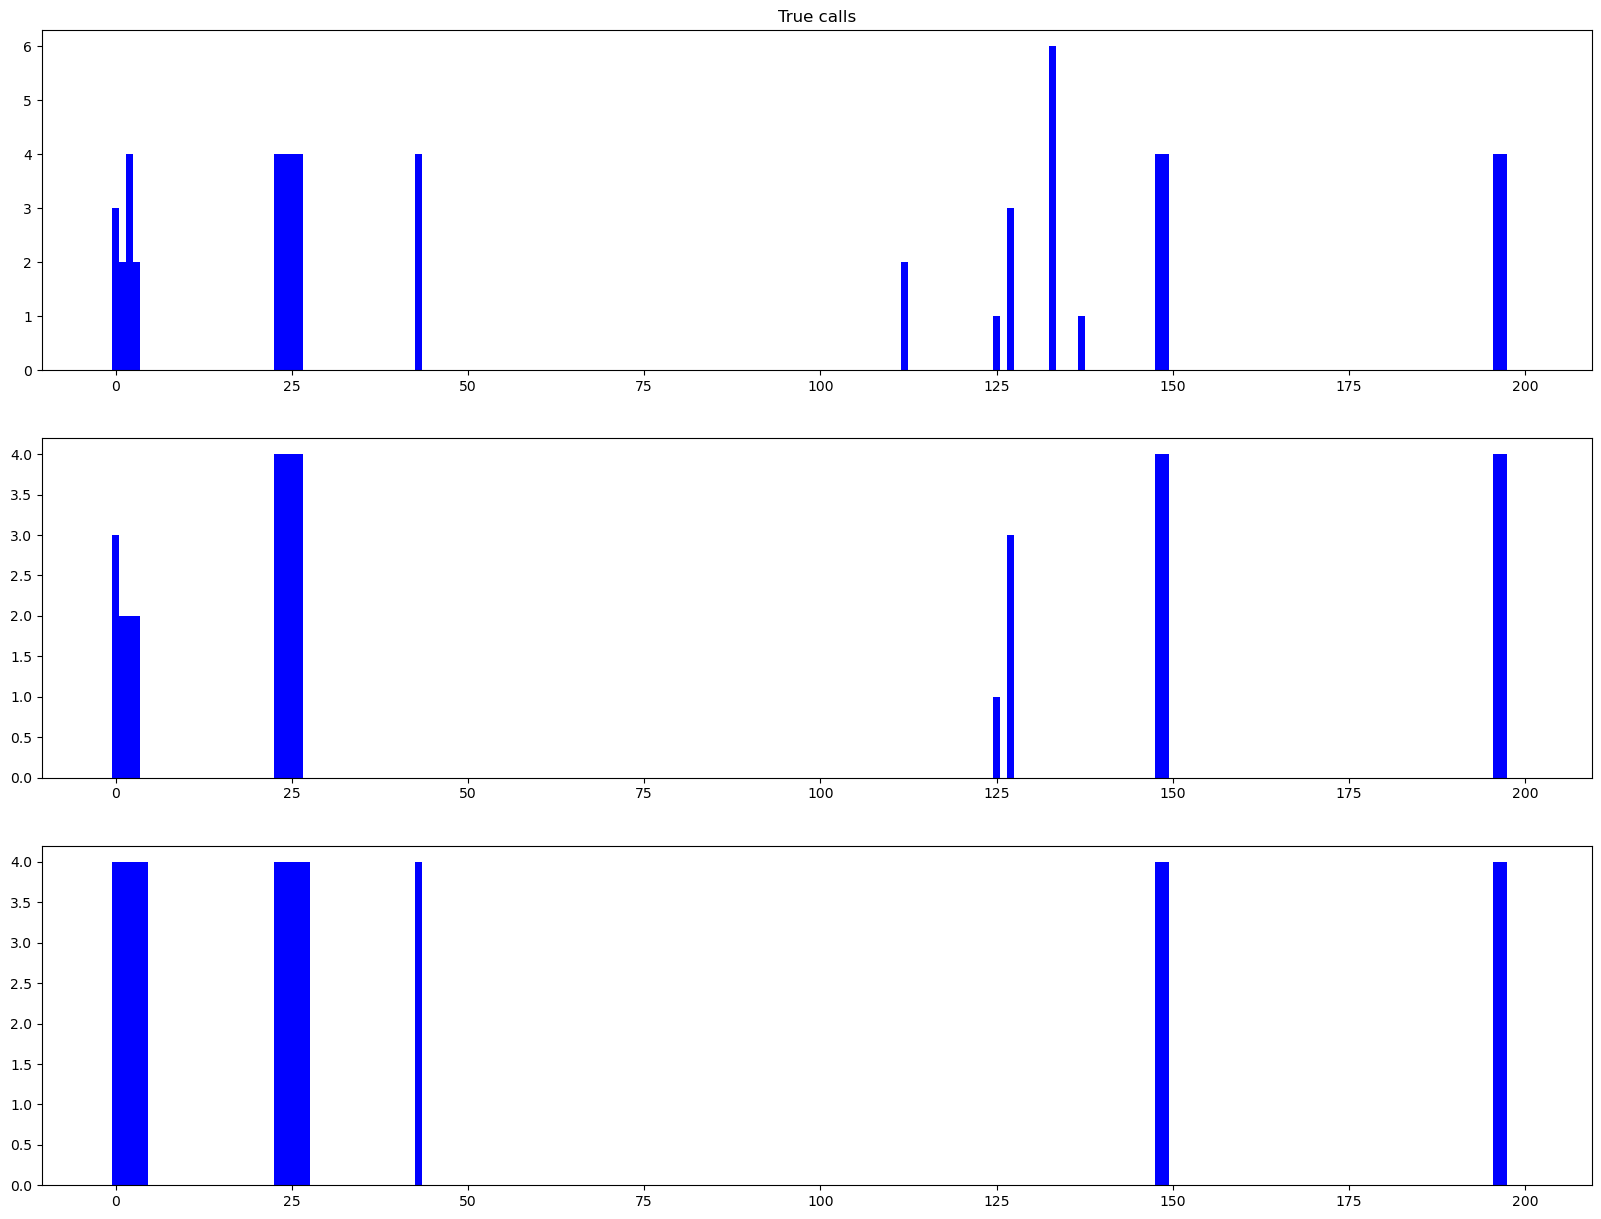

In [160]:
preds = classifier_50.predict(X_test) 
preds_post = postprocess(preds)

post_process_viz(preds, preds_post, y_test, start=13140, stop=13340)

<h4> Evaluate </h4>

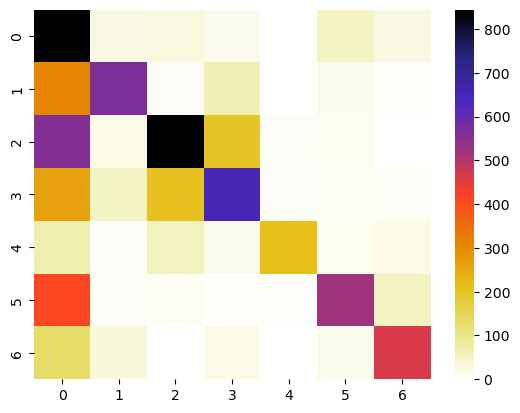

max savings:  6608.9
savings:  3484.62 



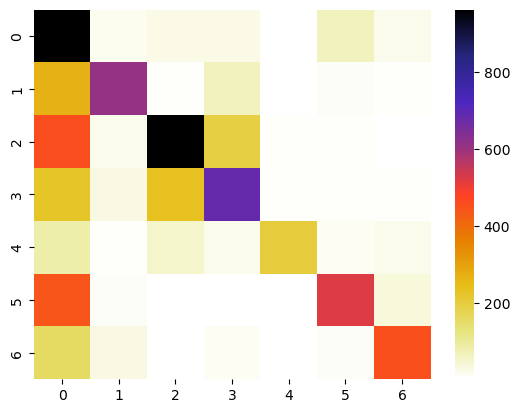

max savings:  6608.9
savings:  3654.7400000000002 



In [167]:
get_savings(preds,y_test,detail=2)
get_savings(preds_post,y_test,detail=2)

<h3> Better parameters </h3>

<h4> Train </h4>

In [170]:
classifier_search_50 = RandomForestClassifier(bootstrap = False, criterion = 'log_loss',
 max_depth = 40,
 max_features = 'sqrt',
 min_samples_leaf = 1,
 min_samples_split = 2,
 n_estimators = 400)
 
classifier_search_50.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=40,
                       n_estimators=400)

<h4> Predict and post-process </h4>

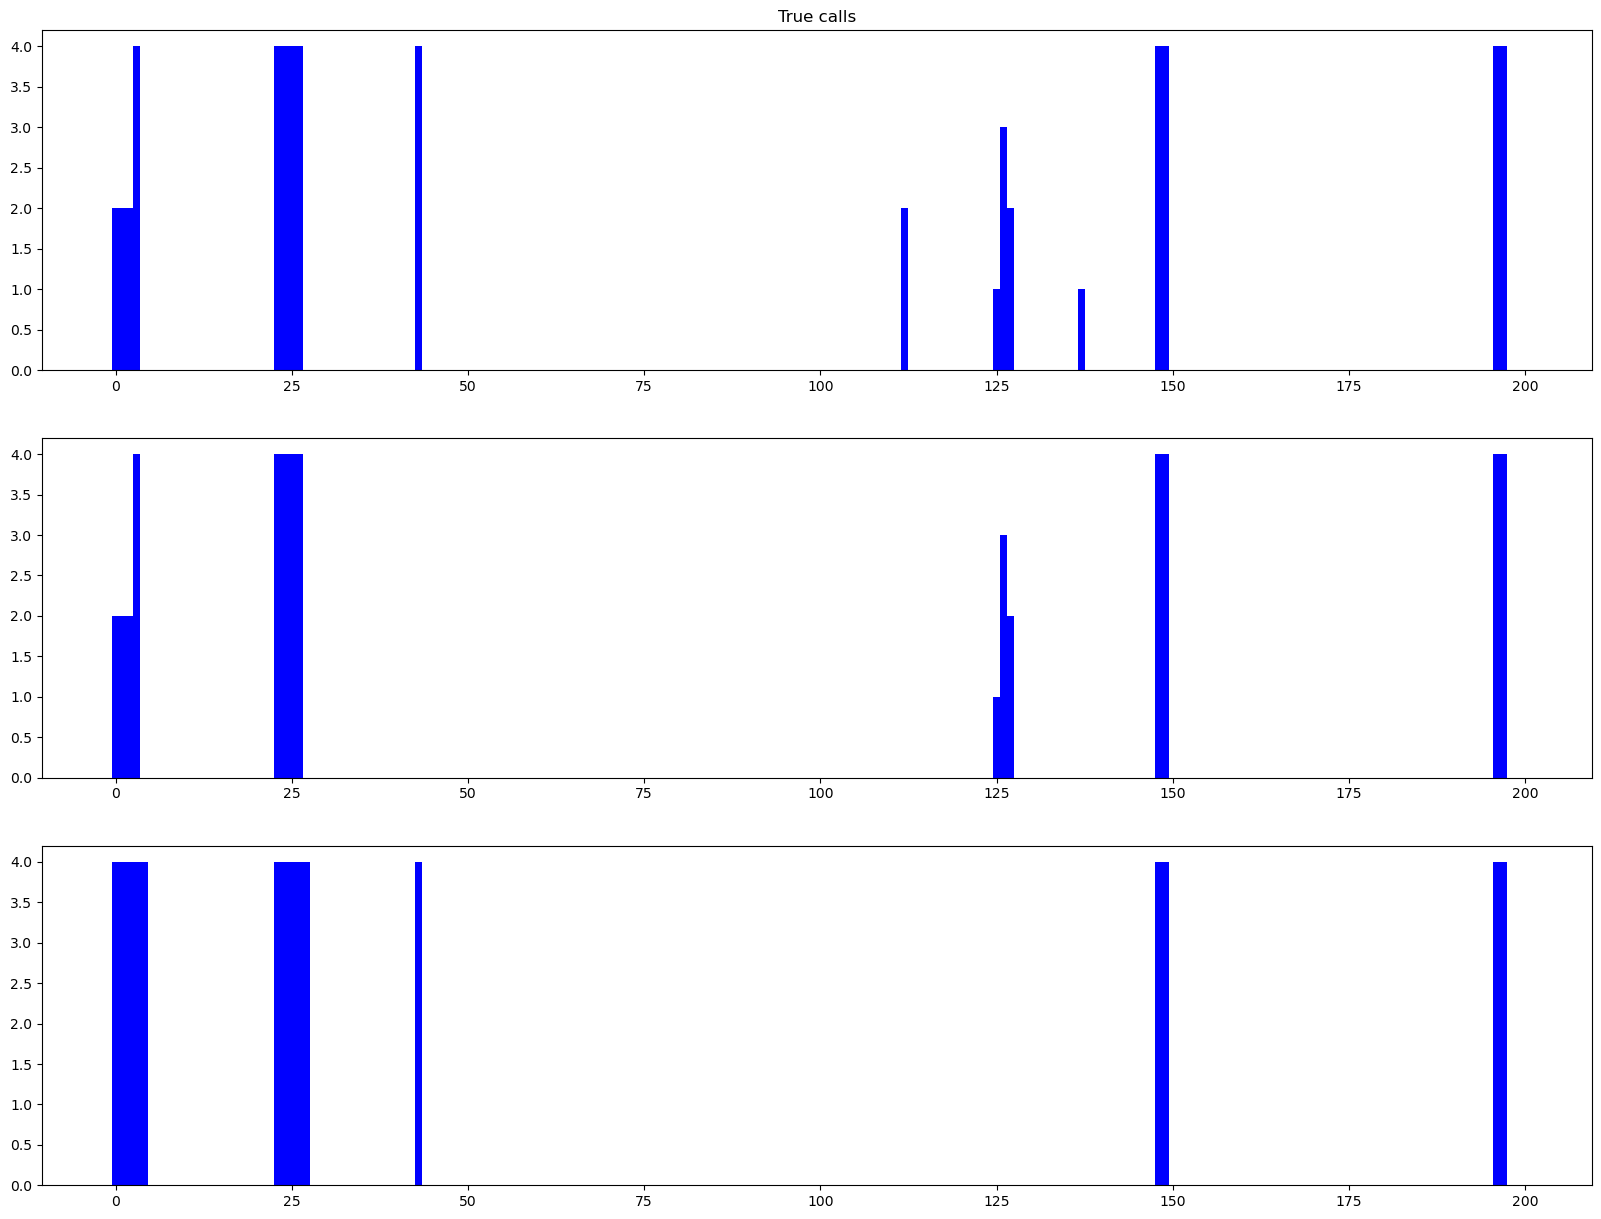

In [171]:
preds_search = classifier_search_50.predict(X_test) 
preds_post_search = postprocess(preds_search)

post_process_viz(preds_search, preds_post_search, y_test, start=13140, stop=13340)

<h4> Evaluate </h4>

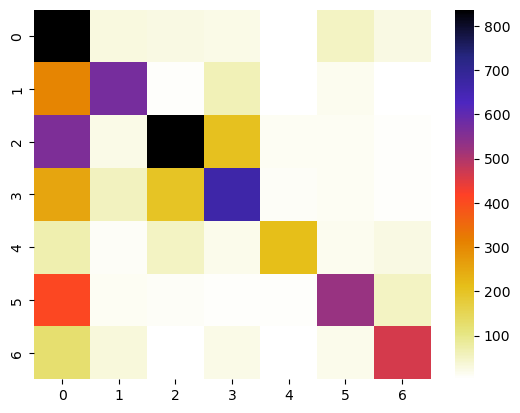

max savings:  6608.9
savings:  3501.2799999999997 



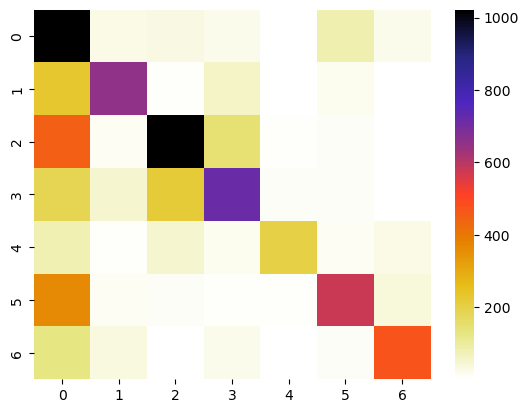

max savings:  6608.9
savings:  3915.1000000000004 



In [172]:
get_savings(preds_search,y_test,detail=2)
get_savings(preds_post_search,y_test,detail=2)

<h3> stacking </h3>

<h4> additional data prep </h4>

In [9]:
y_test_bin = y_test.copy()
y_test_bin[y_test_bin != 0] = 1

y_train_bin = y_train.copy()
y_train_bin[y_train_bin != 0] = 1

X_train_bin = X_train.copy()
X_train_bin['call'] = y_train_bin

<h4> Train classifier for bird/no bird</h4>

In [10]:
classifier_search_50_bin = RandomForestClassifier(bootstrap = False, criterion = 'log_loss',
 max_depth = 40,
 max_features = 'sqrt',
 min_samples_leaf = 1,
 min_samples_split = 2,
 n_estimators = 400)
 
classifier_search_50_bin.fit(X_train,y_train_bin)

RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=40,
                       n_estimators=400)

<h4> Predict and post-process for bird/no bird </h4>

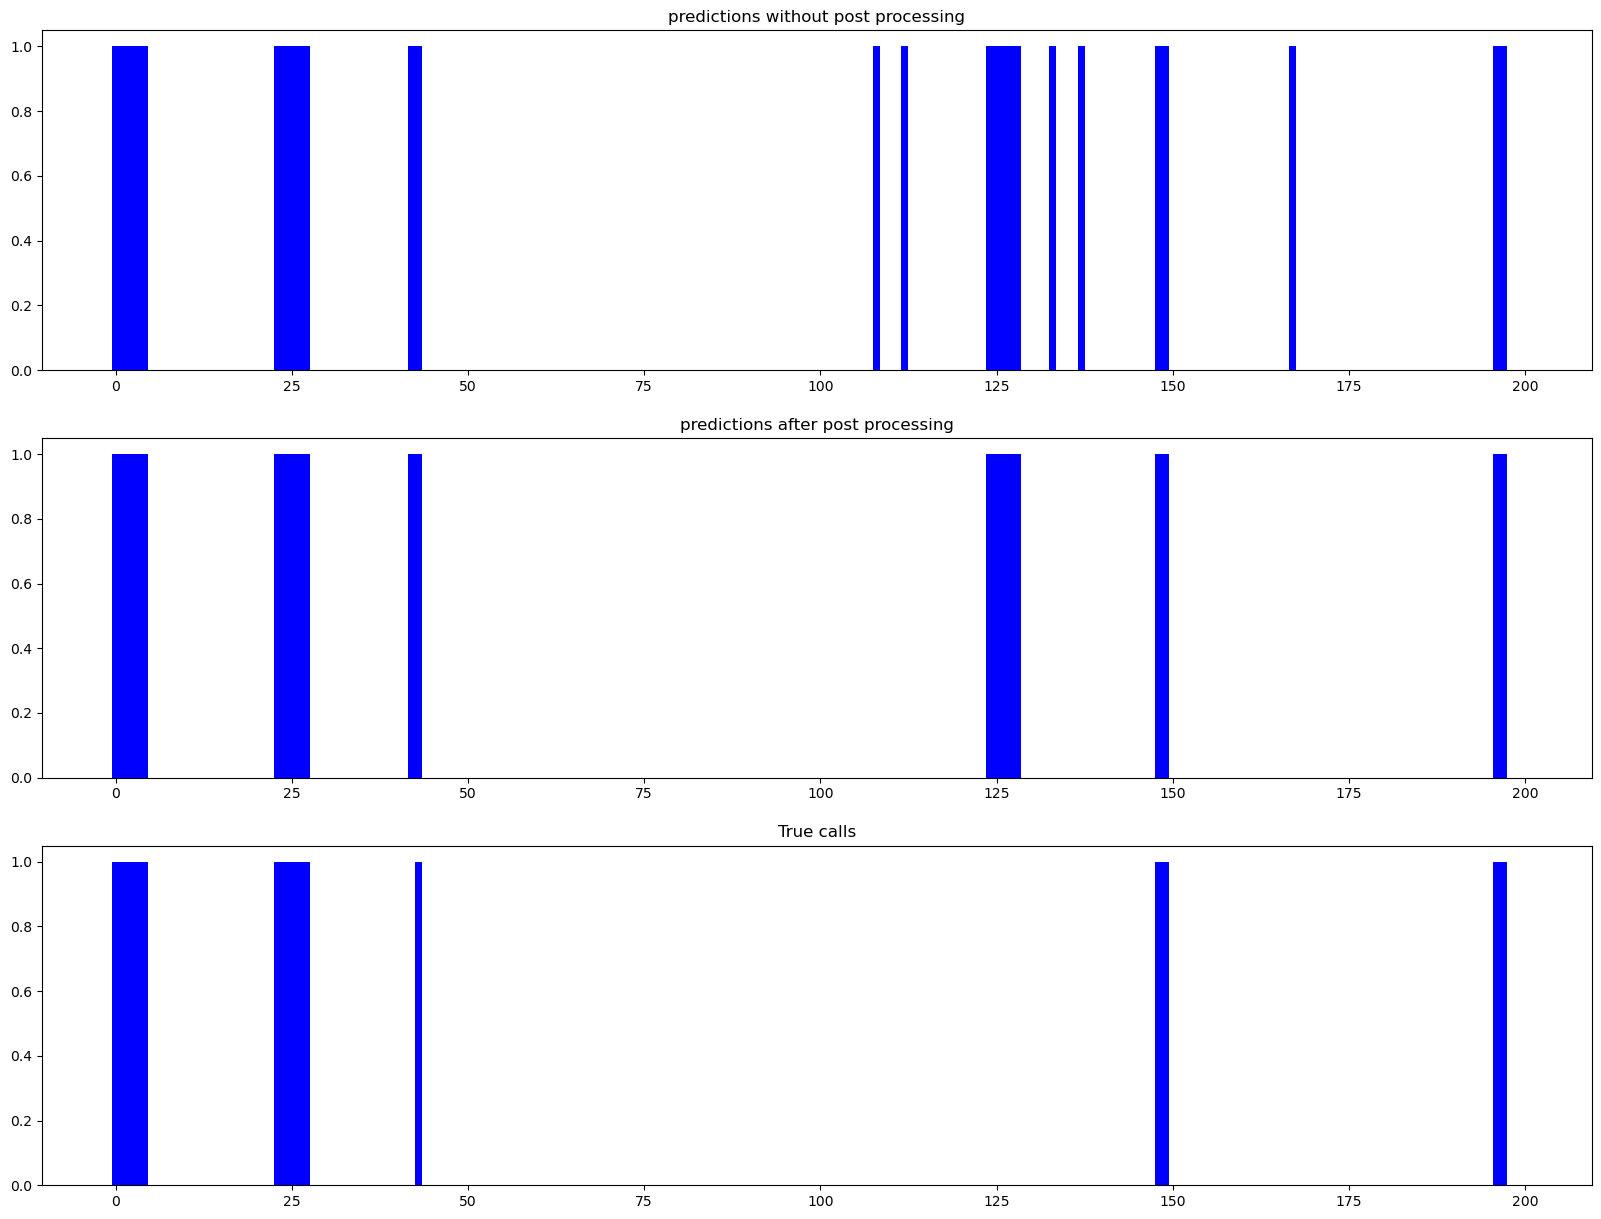

In [74]:
preds_search_bin = classifier_search_50_bin.predict(X_test) 
preds_search_bin_post = postprocess(preds_search_bin)

post_process_viz(preds_search_bin, preds_search_bin_post, y_test_bin, start=13140, stop=13340)

<h4> Train classifier for classes</h4>

In [12]:
classifier_search_50_stack = RandomForestClassifier(bootstrap = False, criterion = 'log_loss',
 max_depth = 40,
 max_features = 'sqrt',
 min_samples_leaf = 1,
 min_samples_split = 2,
 n_estimators = 400)
 
classifier_search_50_stack.fit(X_train_bin,y_train)

RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=40,
                       n_estimators=400)

<h4> Predict and post-process </h4>

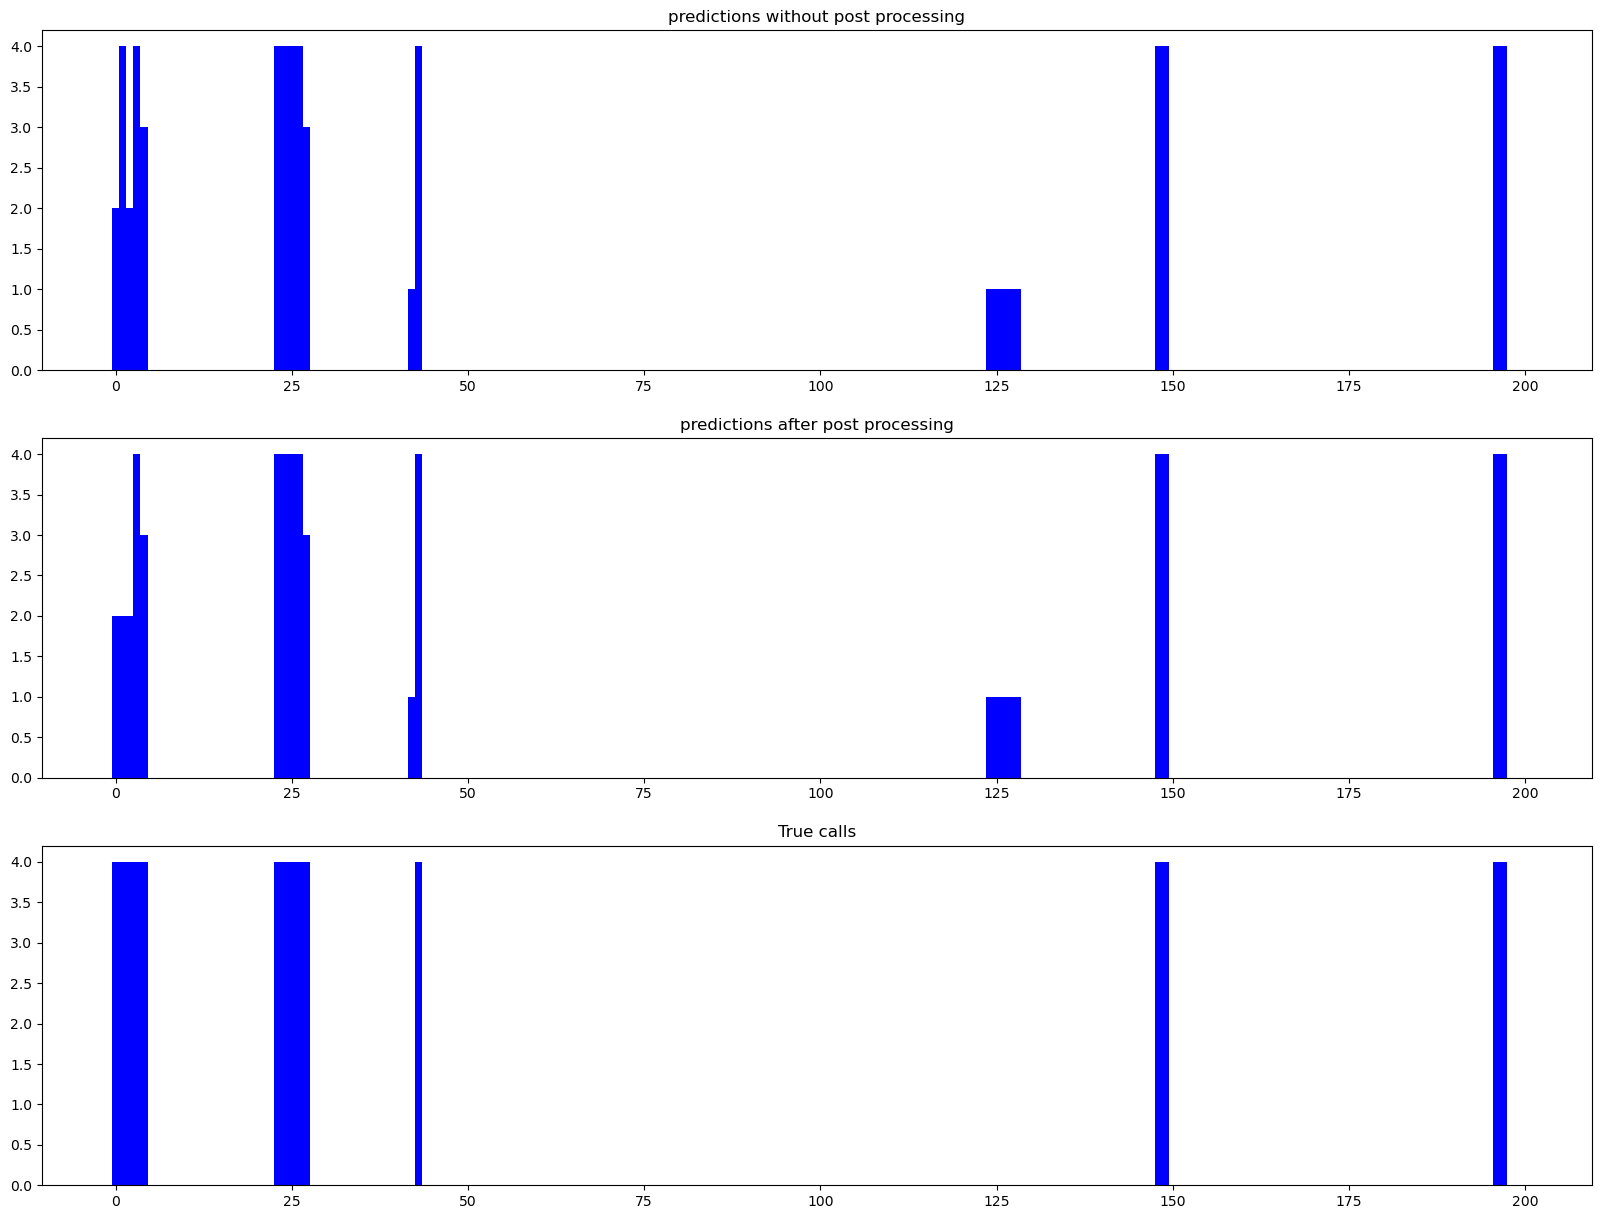

In [80]:
X_test_bin = X_test.copy()
X_test_bin['call'] = preds_search_bin_post

preds_search_stack =  classifier_search_50_stack.predict(X_test_bin) 
preds_search_stack_post = postprocess(preds_search_stack)

post_process_viz(preds_search_stack, preds_search_stack_post, y_test, start=13140, stop=13340)

<h4> Evaluate </h4>

confusion matrix
 [[13622   112   158   115     1   189    61]
 [   98   711    19    89     1    43     5]
 [  293    34   996   283    10    35     2]
 [   79    58   290   729     9    22     9]
 [   53     8    50    31   213    18    25]
 [  241    18    36    22     7   644    49]
 [   64    42    12    30     2    23   493]]


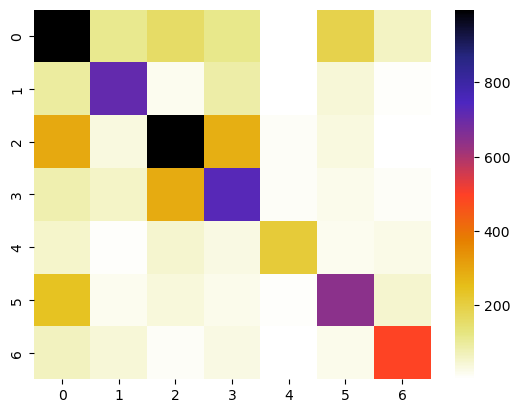

max savings:  6608.9
savings:  3990.6899999999996 

confusion matrix
 [[13615   118   157   105     1   200    62]
 [   98   733    13    77     1    40     4]
 [  273    19  1141   198     3    18     1]
 [   77    47   299   737    12    17     7]
 [   53     8    58    29   207    20    23]
 [  240     8    30    16     7   671    45]
 [   64    40    12    29     2     9   510]]


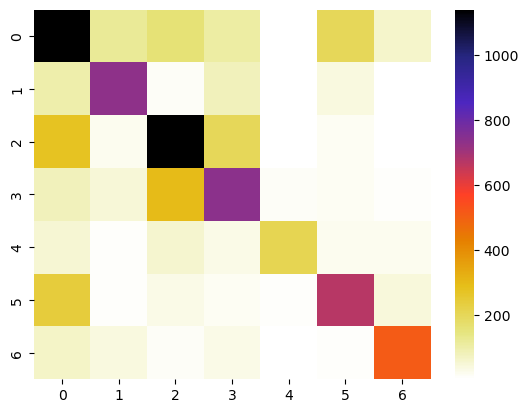

max savings:  6608.9
savings:  4221.09 



In [81]:
get_savings(preds_search_stack,y_test,detail=1)
get_savings(preds_search_stack_post,y_test,detail=1)

<h4> Predictions for challenge </h4>

In [105]:
from csv import writer

with open('Predictions/Prediction.csv', 'w', newline='') as file:
    writer_object = writer(file)
    for i,test in enumerate(data_test_50):

        chall_preds_bin = classifier_search_50_bin.predict(test) 
        chall_preds_bin_post = postprocess(chall_preds_bin)

        test_bin = test.copy()
        test_bin['call'] = chall_preds_bin_post

        chall_preds_stack =  classifier_search_50_stack.predict(test_bin) 
        chall_preds_stack_post = postprocess(chall_preds_stack)
        
        if i < 10:
            lis_t = ['test0' + str(i)]
            for value in chall_preds_stack_post:
                lis_t.append(str(value))
            writer_object.writerow(lis_t)
        else:
            lis_t = ['test' + str(i)]
            for value in chall_preds_stack_post:
                lis_t.append(str(value))
            writer_object.writerow(lis_t)
    file.close()

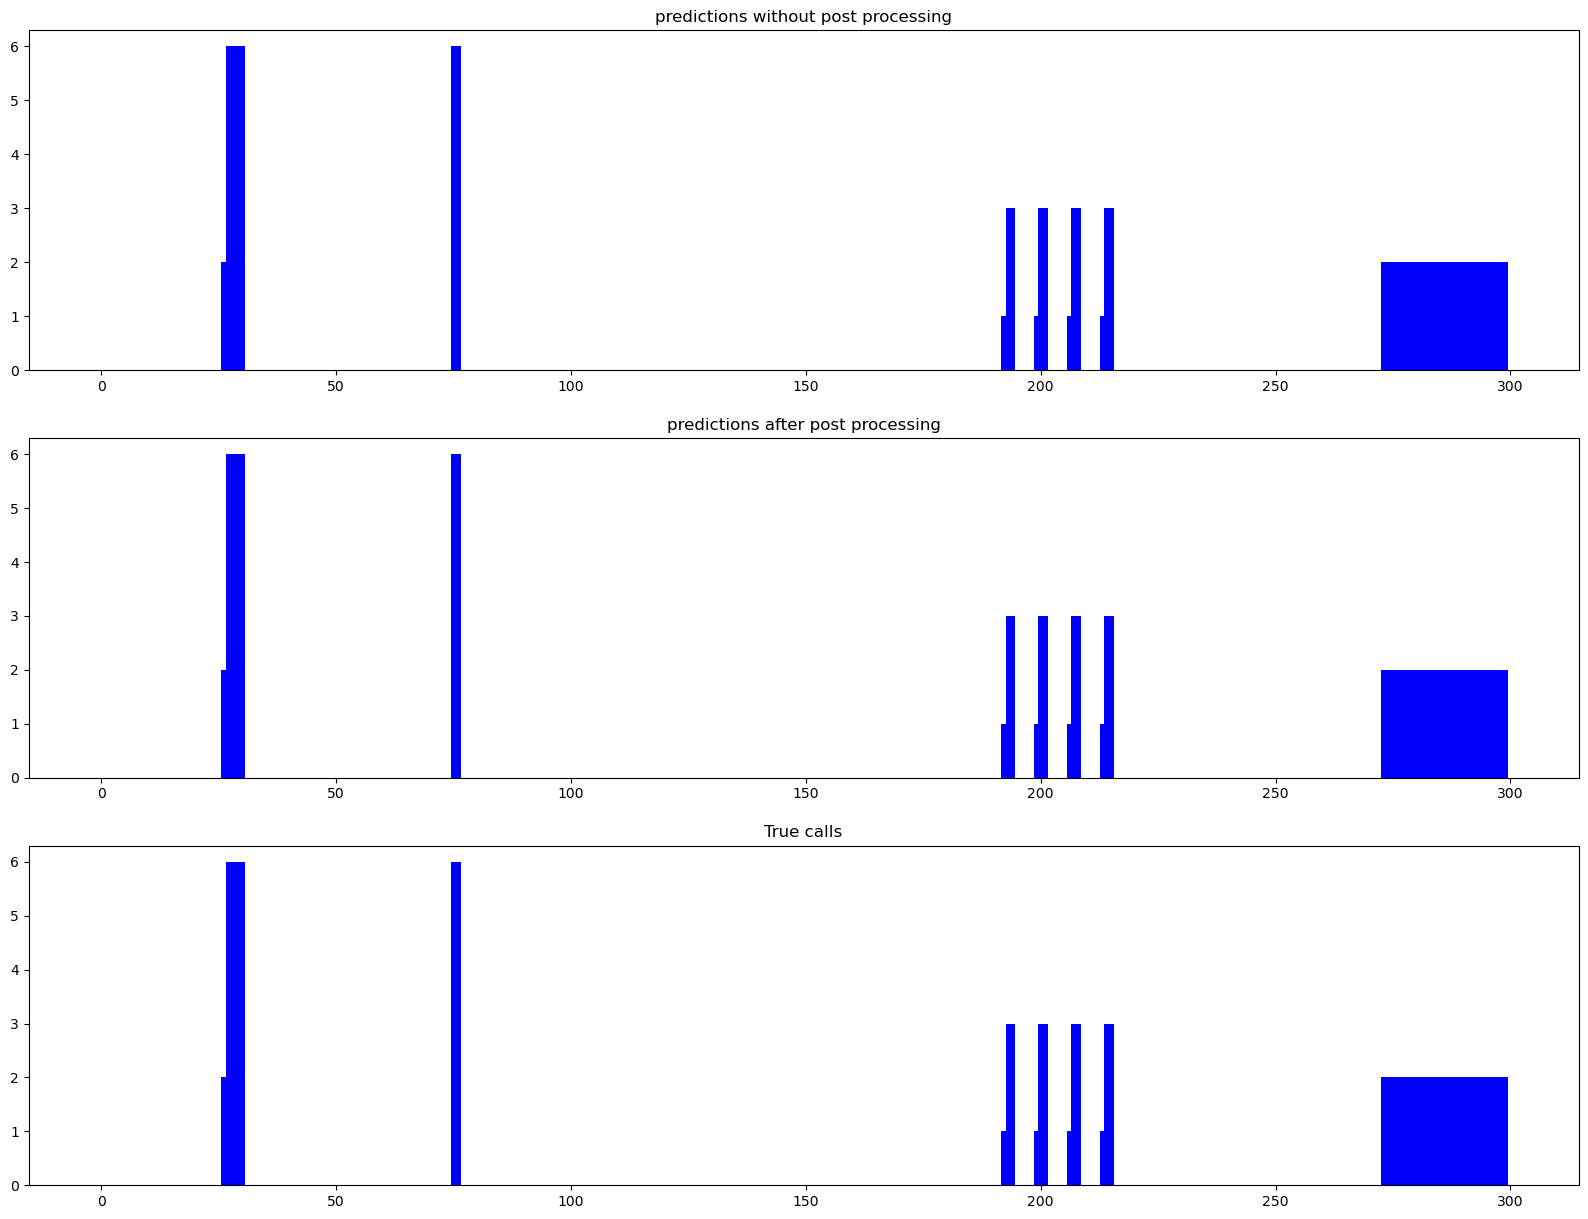

In [107]:
post_process_viz(chall_preds_stack_post, chall_preds_stack_post, chall_preds_stack_post, start=0, stop=300)

<h2> temp </h2>

In [134]:
classifier_50 = RandomForestClassifier(random_state = 42)
classifier_50_weightless = RandomForestClassifier(random_state = 42)
 
classifier_50.fit(X_train,y_train, sample_weight = weights_train)
classifier_50_weightless.fit(X_train,y_train)
# make prediction 
preds = classifier_50.predict(X_test) 
preds_weightless = classifier_50_weightless.predict(X_test) 
# check performance
accuracy_score(preds,y_test) 
accuracy_score(preds_weightless,y_test) 

0.856058350699613

In [27]:
classifier_search_50 = RandomForestClassifier(bootstrap = False, criterion = 'log_loss',
 max_depth = 40,
 max_features = 'sqrt',
 min_samples_leaf = 1,
 min_samples_split = 2,
 n_estimators = 400)
 
classifier_search_50.fit(X_train,y_train)
# make prediction 
preds = classifier_search_50.predict(X_test) 
# check performance
accuracy_score(preds,y_test)

0.8619628857794979

<h3>Prediction and Post-processed Prediction</h3>

In [135]:
#preds = classifier_search_50.predict(X_test)
preds = classifier_50.predict(X_test) 
preds_weightless = classifier_50_weightless.predict(X_test) 
preds_post = postprocess(preds)
preds_post_weightless = postprocess(preds_weightless)

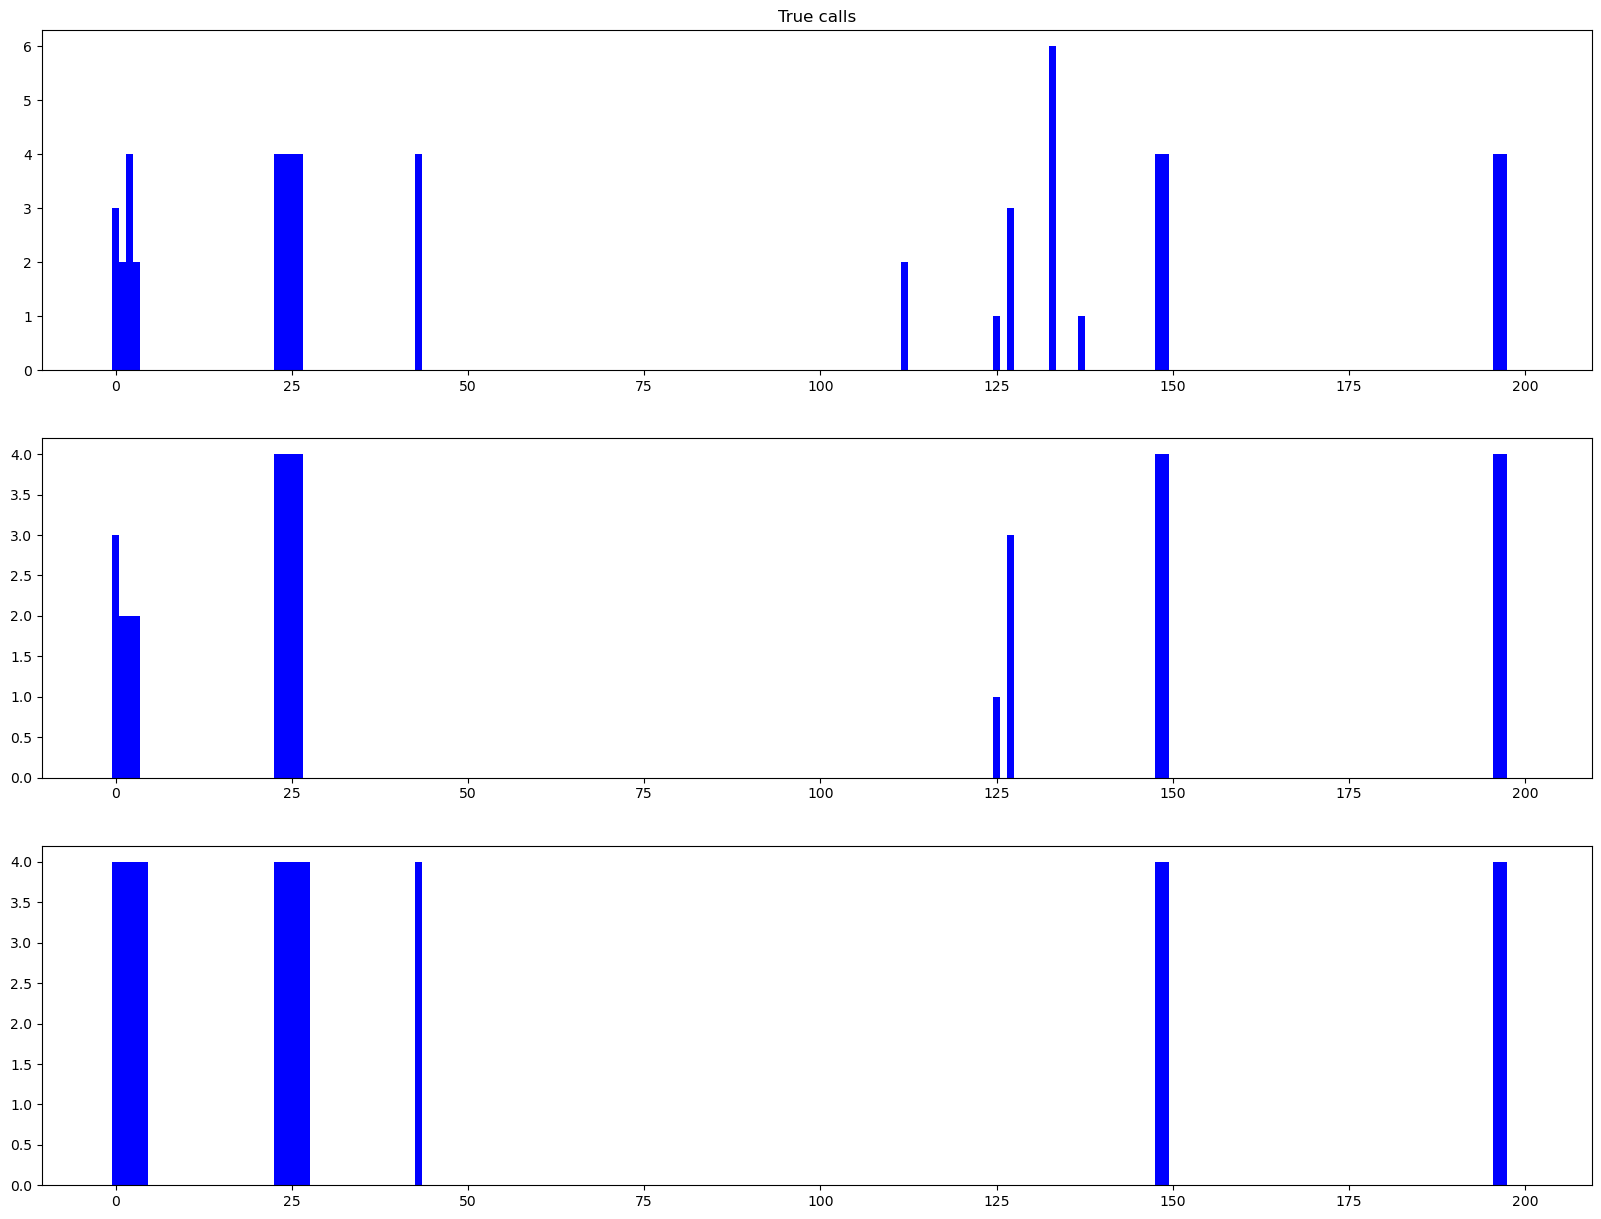

In [158]:
post_process_viz(preds, preds_post, y_test, start=13140, stop=13340)

<h3> eval </h3>

0.8525354768284211
0.8698025205914459 

F1 = 0.6706280975663149
Precision = 0.7854005547854025
Recall = 0.5997015212035831
confusion matrix
 [[14125    18    27    24     1    37    26]
 [  336   533     8    68     2    12     7]
 [  581    25   771   246    17    10     3]
 [  287    40   214   629     7     9    10]
 [   72     6    49    21   212    15    23]
 [  477    10     8     3     5   461    53]
 [  150    28     2    15     2    18   451]]


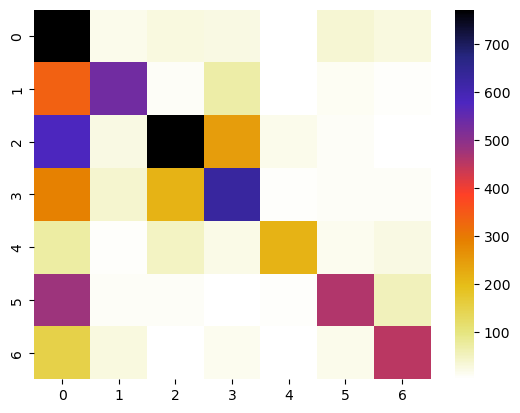

max savings:  6608.9
savings:  3244.73 

F1 = 0.7086001582191531
Precision = 0.815255123738012
Recall = 0.6386988720013885
confusion matrix
 [[14103    19    25    24     1    64    22]
 [  268   607     6    64     2    12     7]
 [  458    23   962   194     8     7     1]
 [  226    31   237   681     7     8     6]
 [   81     6    52    21   202    15    21]
 [  441     9     4     3     4   520    36]
 [  157    28     2    13     2     9   455]]


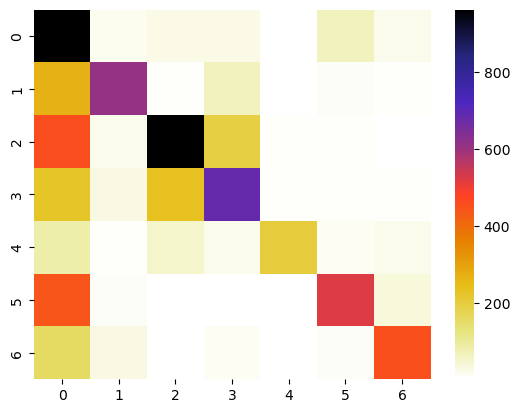

max savings:  6608.9
savings:  3654.7400000000002 

F1 = 0.710685996272254
Precision = 0.8031564112905257
Recall = 0.6472225463206376
confusion matrix
 [[14066    26    39    24     1    79    23]
 [  232   637     5    67     2    18     5]
 [  461    19   967   185    10    11     0]
 [  200    46   234   684    11    16     5]
 [   78     7    57    19   202    12    23]
 [  414     9     5     7     6   540    36]
 [  139    33     2    18     2    13   459]]


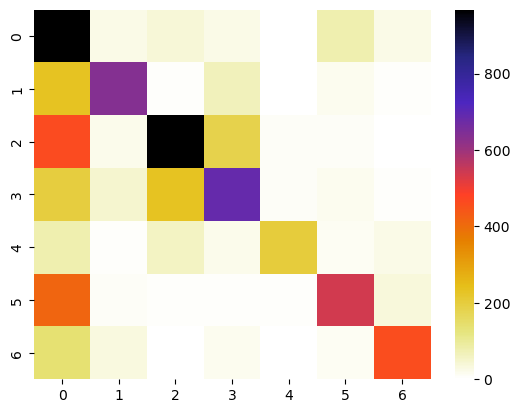

max savings:  6608.9
savings:  3730.03 



In [140]:
print(accuracy_score(preds,y_test))
print(accuracy_score(preds_post,y_test), '\n')
get_savings(preds,y_test)
get_savings(preds_post,y_test)
get_savings(preds_post_weightless,y_test)

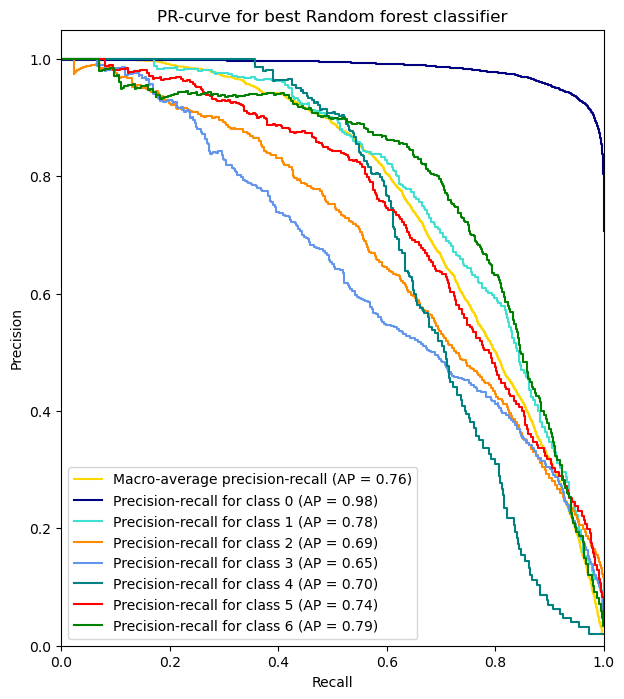

In [46]:
prec_rec(classifier_search_50, X_test, y_test, title='PR-curve for best Random forest classifier', post = True)